<a href="https://colab.research.google.com/github/maydogan23/Spark-NLP/blob/main/Task-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Dataset Selection:**


In [1]:
# 1) Remount and cd into your folder
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/SPARK')    # ← adjust this to where you actually put your CSV

!ls -l



Mounted at /content/drive
total 1143653
-rw------- 1 root root        179 May  2 17:00 'Adsız doküman.gdoc'
-rw------- 1 root root     963697 Apr 30 13:53  claude.ipynb
-rw------- 1 root root       1212 Apr 29 21:38  colab.sh
drwx------ 2 root root       4096 Apr 30 11:45  custom_ner_logs
drwx------ 2 root root       4096 Apr 30 11:45  custom_ner_test.parquet
-rw------- 1 root root      83653 May 11 20:36  entity_distribution.png
-rw------- 1 root root      54871 May 11 20:36  entity_f1_scores.png
drwx------ 2 root root       4096 May 11 03:38  final_conll_with_sentences
-rw------- 1 root root 1115906652 May 11 08:51  final_conll_with_sentences.conll
-rw------- 1 root root    2949826 May  3 10:14  final_conll_with_sentences_eski.conll
-rw------- 1 root root        103 May  1 21:02  final_merged_conll.tsv
-rw------- 1 root root    7893089 May  1 12:42 'Interview Task adlı not defterinin kopyası'
-rw------- 1 root root    7897184 Apr 30 21:19  Interview_Task.ipynb
-rw------- 1 root root

In [2]:
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, when, arrays_zip, monotonically_increasing_id
from pyspark.sql.window import Window


In [3]:
import json
import os

license_path = "/content/drive/MyDrive/SPARK/licensekey.json"

if os.path.exists(license_path):
    with open(license_path) as f:
        license_keys = json.load(f)

    locals().update(license_keys)
    os.environ.update(license_keys)
    print(f"License file loaded successfully: {license_path}")
    os.environ.update(license_keys)

License file loaded successfully: /content/drive/MyDrive/SPARK/licensekey.json


In [4]:
!pip install --upgrade -q pyspark==3.4.1 spark-nlp==6.0.0

!pip install --upgrade -q spark-nlp-jsl --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

!pip install -q spark-nlp-display

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.9/684.9 kB 42.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.3 requires pyspark[connect]>=3.5, but you have pyspark 3.4.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.4/557.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.0 MB/s eta 0:00:00


In [5]:
import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *
from sparknlp.training import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.base import *
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pandas as pd

params = {
    "spark.driver.memory": "40G",
    "spark.kryoserializer.buffer.max": "2000M",
    "spark.driver.maxResultSize": "8G",
    "spark.sql.shuffle.partitions": "16",
    "spark.default.parallelism": "16"
}

spark = sparknlp_jsl.start(os.environ.get('SECRET', ''), params=params)

print("Spark NLP Versiyonu:", sparknlp.version())
print("Spark NLP JSL Versiyonu:", sparknlp_jsl.version())
print("Apache Spark Versiyonu:", spark.version)

Spark NLP Versiyonu: 6.0.0
Spark NLP JSL Versiyonu: 6.0.0
Apache Spark Versiyonu: 3.4.1


In [9]:
file_path = "/content/drive/MyDrive/SPARK/mtsamples_classifier.csv"
pdf = pd.read_csv(file_path)

if "text" not in pdf.columns:
    pdf = pdf.rename(columns={pdf.columns[1]: "text"})

pdf = pdf.dropna(subset=["text"])
spark_df = spark.createDataFrame(pdf[["text"]])
print("Spark DataFrame oluşturuldu:", spark_df.count(), "kayıt")


Spark DataFrame oluşturuldu: 630 kayıt


In [14]:
# Document Pipeline bileşenlerini tanımlama
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# Word Embeddings modelini yükleme
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

# NER modellerini yükleme
clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("clinical_ner")

deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("deid_ner")

posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("posology_ner")

# Her NER modeli için ayrı converter'lar
clinical_converter = NerConverter() \
    .setInputCols(["sentence", "token", "clinical_ner"]) \
    .setOutputCol("clinical_chunks")

deid_converter = NerConverter() \
    .setInputCols(["sentence", "token", "deid_ner"]) \
    .setOutputCol("deid_chunks")

posology_converter = NerConverter() \
    .setInputCols(["sentence", "token", "posology_ner"]) \
    .setOutputCol("posology_chunks")

print("NER modelleri hazırlandı.")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]
NER modelleri hazırlandı.


In [15]:
# Pipeline oluşturma
ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    deid_ner,
    posology_ner,
    clinical_converter,
    deid_converter,
    posology_converter
])

# Boş DataFrame ile model oluşturma
empty_df = spark.createDataFrame([['']]).toDF("text")
print("NER pipeline oluşturuluyor...")
ner_model = ner_pipeline.fit(empty_df)
print("NER pipeline başarıyla oluşturuldu.")

NER pipeline oluşturuluyor...
NER pipeline başarıyla oluşturuldu.


In [ ]:
# Örnek metin üzerinde test
sample_text = spark.createDataFrame([["Patient was prescribed Aspirin 10mg daily for heart disease. John Doe visited Dr. Smith at Memorial Hospital on January 15, 2023."]]).toDF("text")
result = ner_model.transform(sample_text)

# NER sonuçlarını inceleyelim
print("\n=== Farklı NER Modellerinin Sonuçları ===")
print("\nPosology NER Chunks:")
result.select(F.explode(F.arrays_zip(
    result.posology_chunks.result,
    result.posology_chunks.metadata
)).alias("chunks")) \
.select(
    F.expr("chunks['0']").alias("chunk"),
    F.expr("chunks['1']['entity']").alias("entity")
).show(truncate=False)

print("\nDeID NER Chunks:")
result.select(F.explode(F.arrays_zip(
    result.deid_chunks.result,
    result.deid_chunks.metadata
)).alias("chunks")) \
.select(
    F.expr("chunks['0']").alias("chunk"),
    F.expr("chunks['1']['entity']").alias("entity")
).show(truncate=False)

print("\nClinical NER Chunks:")
result.select(F.explode(F.arrays_zip(
    result.clinical_chunks.result,
    result.clinical_chunks.metadata
)).alias("chunks")) \
.select(
    F.expr("chunks['0']").alias("chunk"),
    F.expr("chunks['1']['entity']").alias("entity")
).show(truncate=False)

# Token düzeyinde NER tahminlerini karşılaştırma
token_df = result.select(
    F.explode(F.arrays_zip(
        result.token.result,
        result.clinical_ner.result,
        result.deid_ner.result,
        result.posology_ner.result
    )).alias("cols")
).select(
    F.expr("cols['0']").alias("token"),
    F.expr("cols['1']").alias("clinical_label"),
    F.expr("cols['2']").alias("deid_label"),
    F.expr("cols['3']").alias("posology_label")
)

# Tokenleri ve NER etiketlerini görüntüleme
print("\n=== Token Düzeyinde NER Karşılaştırması ===")
token_df.show(truncate=False)


=== Farklı NER Modellerinin Sonuçları ===

Posology NER Chunks:
+-------+---------+
|chunk  |entity   |
+-------+---------+
|Aspirin|DRUG     |
|10mg   |STRENGTH |
|daily  |FREQUENCY|
+-------+---------+


DeID NER Chunks:
+-----------------+--------+
|chunk            |entity  |
+-----------------+--------+
|John Doe         |NAME    |
|Smith            |NAME    |
|Memorial Hospital|LOCATION|
|January 15, 2023 |DATE    |
+-----------------+--------+


Clinical NER Chunks:
+-------------+---------+
|chunk        |entity   |
+-------------+---------+
|Aspirin      |TREATMENT|
|heart disease|PROBLEM  |
+-------------+---------+


=== Token Düzeyinde NER Karşılaştırması ===
+----------+--------------+----------+--------------+
|token     |clinical_label|deid_label|posology_label|
+----------+--------------+----------+--------------+
|Patient   |O             |O         |O             |
|was       |O             |O         |O             |
|prescribed|O             |O         |O          

In [ ]:
def process_ner_results_to_conll(token_df, output_file="merged_ner.conll"):
    """
    NER sonuçlarını önceliğe göre birleştirerek CoNLL dosyası oluşturur

    Parametreler:
    token_df: Token düzeyinde NER çıktılarını içeren DataFrame
    output_file: Çıktı dosyasının adı
    """
    print("DataFrame sütunları:", token_df.columns)

    print("Token bilgileri toplanıyor...")
    tokens_list = token_df.collect()

    data = []
    for row in tokens_list:
        print(f"Row keys: {row.__fields__}")

        data.append({
            'token': row['token'],
            'clinical_label': row['clinical_label'],
            'deid_label': row['deid_label'],
            'posology_label': row['posology_label']
        })

    import pandas as pd
    pandas_df = pd.DataFrame(data)

    # Metinleri ve etiketleri birleştir
    print("Etiketler önceliğe göre birleştiriliyor...")
    pandas_df['merged_label'] = 'O'

    # Önceliklendirme: posology > deid > clinical
    for idx, row in pandas_df.iterrows():
        if row['posology_label'] != 'O':
            pandas_df.at[idx, 'merged_label'] = row['posology_label']
        elif row['deid_label'] != 'O':
            pandas_df.at[idx, 'merged_label'] = row['deid_label']
        elif row['clinical_label'] != 'O':
            pandas_df.at[idx, 'merged_label'] = row['clinical_label']

    # BIO formatına dönüştür ve CoNLL dosyası oluştur
    print("CoNLL dosyası oluşturuluyor...")
    conll_text = "-DOCSTART- -X- -X- O\n\n"

    prev_label = "O"

    for idx, row in pandas_df.iterrows():
        label = row.merged_label
        if label != "O":
            if prev_label != label:
                bio_label = f"B-{label}"
            else:
                bio_label = f"I-{label}"
        else:
            bio_label = "O"

        conll_text += f"{row.token} NN NN {bio_label}\n"

        if row.token in ['.', '!', '?']:
            conll_text += "\n"

        prev_label = label

    with open(output_file, "w+", encoding="utf-8") as f:
        f.write(conll_text)

    print(f"CoNLL dosyası kaydedildi: {output_file}")
    return conll_text, pandas_df

In [ ]:
# Örnek metindeki etiketleri birleştir ve CoNLL dosyası oluştur
sample_conll, merged_df = process_ner_results_to_conll(token_df, "sample_merged.conll")

# Birleştirilmiş etiketleri göster
print("\n=== Önceliğe Göre Birleştirilmiş Etiketler ===")
print(merged_df[['token', 'clinical_label', 'deid_label', 'posology_label', 'merged_label']].head(20))

DataFrame sütunları: ['token', 'clinical_label', 'deid_label', 'posology_label']
Token bilgileri toplanıyor...
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label', 'posology_label']
Row keys: ['token', 'clinical_label', 'deid_label

In [ ]:
# Token düzeyinde sonuçları topla ve bir CoNLL dosyası oluştur
result_tokens = token_df.collect()

# CoNLL metnini oluştur
conll_text = "-DOCSTART- -X- -X- O\n\n"
prev_label = "O"

for row in result_tokens:
    # Öncelik sırasına göre etiket belirle
    if row["posology_label"] != "O":
        label = row["posology_label"]
    elif row["deid_label"] != "O":
        label = row["deid_label"]
    else:
        label = row["clinical_label"]

    # BIO formatına dönüştür
    if label != "O":
        if prev_label != label:
            bio_label = f"B-{label}"
        else:
            bio_label = f"I-{label}"
    else:
        bio_label = "O"

    # CoNLL formatında satır ekle
    conll_text += f"{row['token']} NN NN {bio_label}\n"

    # Noktalama işareti veya cümle sonu ise yeni bir boş satır ekle
    if row['token'] in ['.', '!', '?']:
        conll_text += "\n"

    prev_label = label

# Dosyaya kaydet
output_file = "sample_merged.conll"
with open(output_file, "w+", encoding="utf-8") as f:
    f.write(conll_text)

print(f"Örnek CoNLL dosyası kaydedildi: {output_file}")

# Sonuçları görüntüle
print("\n=== CoNLL Dosyası İlk 20 Satır ===")
print('\n'.join(conll_text.split('\n')[:20]))

Örnek CoNLL dosyası kaydedildi: sample_merged.conll

=== CoNLL Dosyası İlk 20 Satır ===
-DOCSTART- -X- -X- O

Patient NN NN O
was NN NN O
prescribed NN NN O
Aspirin NN NN B-B-DRUG
10mg NN NN B-B-STRENGTH
daily NN NN B-B-FREQUENCY
for NN NN O
heart NN NN B-B-PROBLEM
disease NN NN B-I-PROBLEM
. NN NN O

John NN NN B-B-NAME
Doe NN NN B-I-NAME
visited NN NN O
Dr NN NN O
. NN NN O

Smith NN NN B-B-NAME


In [11]:
def process_dataset_to_conll_batched(spark_df, ner_model, output_file="merged_ner_batched.conll", batch_size=50, checkpoint_interval=5):
    """
    Parametreler:
    spark_df: İşlenecek veri seti (Spark DataFrame)
    ner_model: NER pipeline modeli
    output_file: Çıktı dosyasının adı
    batch_size: Bir seferde işlenecek metin sayısı
    checkpoint_interval: Kaç batch'te bir checkpoint kaydedileceği
    """
    import time
    start_time = time.time()
    total_count = spark_df.count()
    print(f"Toplam metin sayısı: {total_count}")

    start_batch = 0

    import glob
    checkpoint_files = glob.glob(f"{output_file}.checkpoint_*")
    if checkpoint_files:
        latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1]))
        try:
            start_batch = int(latest_checkpoint.split('_')[-1]) * batch_size
            print(f"Son checkpoint bulundu: {latest_checkpoint}")
            print(f"İşlem {start_batch}. kayıttan devam edecek")

            if start_batch > 0:
                import shutil
                shutil.copy(output_file, f"{output_file}.bak")
                print(f"Önceki dosya yedeklendi: {output_file}.bak")
        except:
            start_batch = 0

    mode = "a+" if start_batch > 0 else "w+"

    with open(output_file, mode, encoding="utf-8") as f:
        if start_batch == 0:
            f.write("-DOCSTART- -X- -X- O\n\n")

        for batch_idx in range(start_batch, total_count, batch_size):
            batch_num = batch_idx // batch_size + 1
            batch_end = min(batch_idx + batch_size, total_count)
            batch_start_time = time.time()

            print(f"Batch {batch_num}/{(total_count+batch_size-1)//batch_size} işleniyor ({batch_idx} - {batch_end})...")

            batch_df = spark_df.limit(batch_end).subtract(spark_df.limit(batch_idx))
            batch_df = batch_df.repartition(4)

            try:
                spark.catalog.clearCache()

                result = ner_model.transform(batch_df)

                print("Token bilgileri toplanıyor...")
                token_data = result.select(
                    "text",
                    F.explode(F.arrays_zip(
                        result.token.result,
                        result.token.begin,
                        result.token.end,
                        result.clinical_ner.result,
                        result.deid_ner.result,
                        result.posology_ner.result,
                        result.sentence.metadata
                    )).alias("cols")
                ).select(
                    "text",
                    F.expr("cols['0']").alias("token"),
                    F.expr("cols['1']").alias("begin"),
                    F.expr("cols['2']").alias("end"),
                    F.expr("cols['3']").alias("clinical_label"),
                    F.expr("cols['4']").alias("deid_label"),
                    F.expr("cols['5']").alias("posology_label"),
                    F.expr("cols['6']['sentence']").alias("sentence_id")
                ).orderBy("text", "begin")

                token_rows = token_data.collect()

                # CoNLL formatı oluştur
                print("CoNLL formatı oluşturuluyor...")
                batch_conll = ""
                current_text = None
                prev_label = "O"
                prev_sentence = None

                for row in token_rows:
                    if current_text != row.text:
                        if current_text is not None:
                            batch_conll += "\n"
                        current_text = row.text
                        batch_conll += f"-DOCSTART- -X- -X- O\n\n"
                        prev_label = "O"
                        prev_sentence = None

                    if prev_sentence is not None and prev_sentence != row.sentence_id:
                        batch_conll += "\n"
                    prev_sentence = row.sentence_id

                    if row.posology_label != "O":
                        label = row.posology_label
                    elif row.deid_label != "O":
                        label = row.deid_label
                    elif row.clinical_label != "O":
                        label = row.clinical_label
                    else:
                        label = "O"

                    if label != "O":
                        if prev_label != label:
                            bio_label = f"B-{label}"
                        else:
                            bio_label = f"I-{label}"
                    else:
                        bio_label = "O"

                    batch_conll += f"{row.token} NN NN {bio_label}\n"

                    if row.token in ['.', '!', '?']:
                        batch_conll += "\n"

                    prev_label = label

                f.write(batch_conll)
                f.flush()

                if batch_num % checkpoint_interval == 0:
                    with open(f"{output_file}.checkpoint_{batch_num}", "w") as cp:
                        cp.write(f"Batch {batch_num} tamamlandı")

                    print(f"Checkpoint kaydedildi: Batch {batch_num}")

                del token_rows, token_data, result, batch_conll
                gc.collect()

                batch_time = time.time() - batch_start_time
                remaining_batches = ((total_count - batch_end) // batch_size) + 1
                remaining_time = remaining_batches * batch_time / 60.0  # dakika

                print(f"Batch {batch_num} tamamlandı - Süre: {batch_time:.2f}s")
                print(f"Tahmini kalan süre: {remaining_time:.2f} dakika")

            except Exception as e:
                print(f"Batch {batch_num} işlenirken hata oluştu: {str(e)}")
                with open(f"{output_file}.error_{batch_num}", "w") as error_file:
                    error_file.write(f"Batch {batch_num} ({batch_idx}-{batch_end}) işlenirken hata: {str(e)}")
                continue

    total_time = (time.time() - start_time) / 60.0  # dakika
    print(f"İşlem tamamlandı! Toplam süre: {total_time:.2f} dakika")
    print(f"CoNLL dosyası oluşturuldu: {output_file}")
    return True

In [16]:
import gc

output_file = "/content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll"

success = process_dataset_to_conll_batched(
    spark_df=spark_df,
    ner_model=ner_model,
    output_file=output_file,
    batch_size=50,
    checkpoint_interval=5
)

spark.catalog.clearCache()
gc.collect()

Toplam metin sayısı: 630
Son checkpoint bulundu: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll.checkpoint_10
İşlem 500. kayıttan devam edecek
Önceki dosya yedeklendi: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll.bak
Batch 11/13 işleniyor (500 - 550)...
Token bilgileri toplanıyor...
CoNLL formatı oluşturuluyor...
Batch 11 tamamlandı - Süre: 51.71s
Tahmini kalan süre: 1.72 dakika
Batch 12/13 işleniyor (550 - 600)...
Token bilgileri toplanıyor...
CoNLL formatı oluşturuluyor...
Batch 12 tamamlandı - Süre: 38.33s
Tahmini kalan süre: 0.64 dakika
Batch 13/13 işleniyor (600 - 630)...
Token bilgileri toplanıyor...
CoNLL formatı oluşturuluyor...
Batch 13 tamamlandı - Süre: 21.33s
Tahmini kalan süre: 0.36 dakika
İşlem tamamlandı! Toplam süre: 1.89 dakika
CoNLL dosyası oluşturuldu: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll


5

CoNLL Dosyasını Analiz Etme


In [ ]:
output_file = "/content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll"


In [ ]:
def analyze_conll_file(file_path):
    """
    CoNLL dosyasını analiz eder ve istatistikler döndürür
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    total_tokens = 0
    labeled_tokens = 0
    entity_counts = {}
    document_count = 0
    sentence_count = 0

    for line in lines:
        line = line.strip()
        if line.startswith("-DOCSTART-"):
            document_count += 1
            continue

        if not line:
            sentence_count += 1
            continue

        parts = line.split()
        if len(parts) >= 4:
            token = parts[0]
            label = parts[3]

            total_tokens += 1

            if label != "O":
                labeled_tokens += 1
                entity_type = label.split("-")[-1]
                entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1

    print(f"CoNLL Dosyası Analizi: {file_path}")
    print(f"Toplam doküman sayısı: {document_count}")
    print(f"Toplam cümle sayısı: {sentence_count}")
    print(f"Toplam token sayısı: {total_tokens}")

    if total_tokens > 0:
        print(f"Etiketli token sayısı: {labeled_tokens} ({labeled_tokens/total_tokens*100:.2f}%)")

    print("\nVarlık Türleri ve Sayıları:")
    for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{entity}: {count}")

    return entity_counts

entity_counts = analyze_conll_file(output_file)

CoNLL Dosyası Analizi: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll
Toplam doküman sayısı: 619
Toplam cümle sayısı: 53204
Toplam token sayısı: 368369
Etiketli token sayısı: 97036 (26.34%)

Varlık Türleri ve Sayıları:
PROBLEM: 48182
TREATMENT: 27920
TEST: 12074
DRUG: 3323
STRENGTH: 1061
DATE: 1033
FREQUENCY: 751
LOCATION: 523
AGE: 447
DOSAGE: 416
ROUTE: 378
NAME: 362
DURATION: 227
FORM: 206
PROFESSION: 101
ID: 28
CONTACT: 4


 Görselleştirme


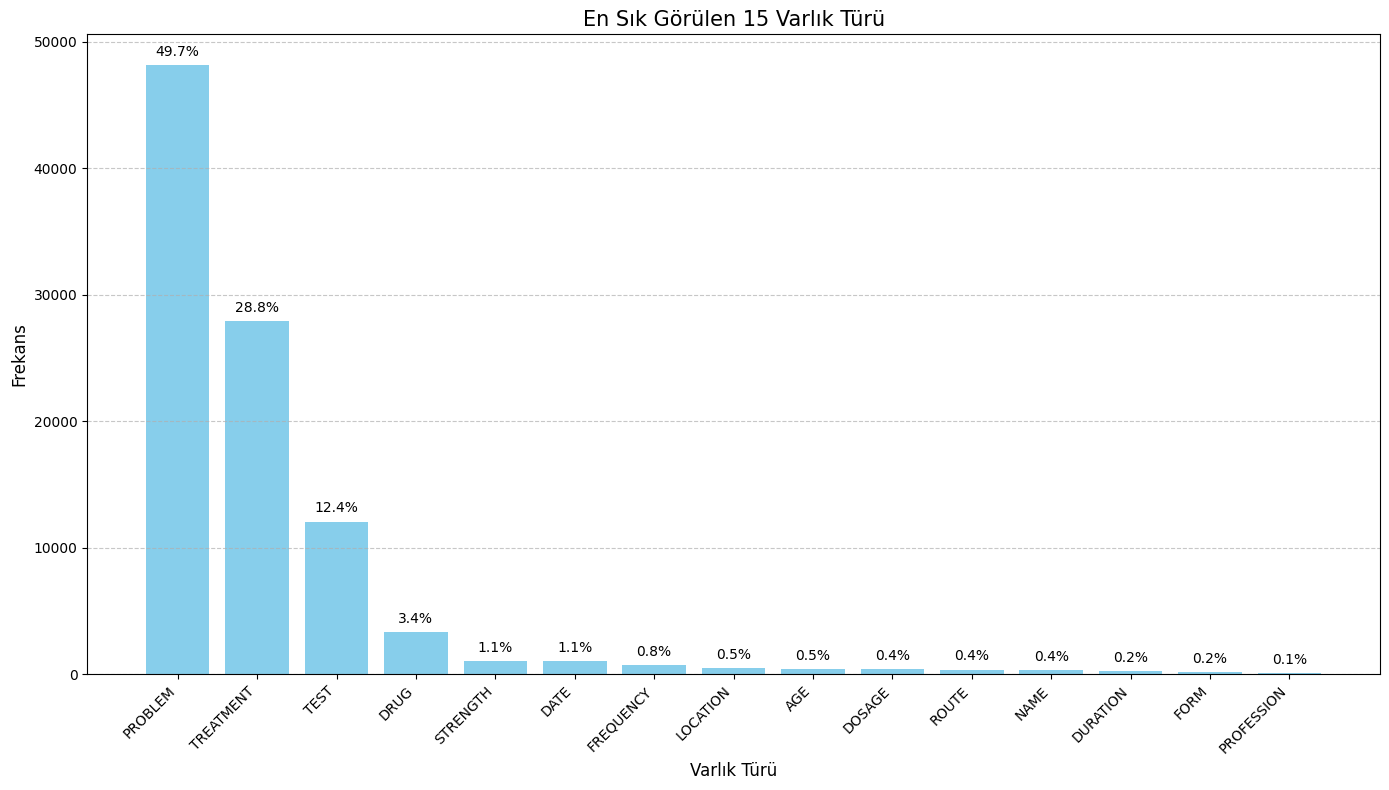

In [ ]:
import matplotlib.pyplot as plt

# En sık görülen 15 varlık türünü görselleştir
top_entities = dict(sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)[:15])

plt.figure(figsize=(14, 8))
plt.bar(top_entities.keys(), top_entities.values(), color='skyblue')
plt.title('En Sık Görülen 15 Varlık Türü', fontsize=15)
plt.xlabel('Varlık Türü', fontsize=12)
plt.ylabel('Frekans', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Yüzdeleri ekle
for i, (key, value) in enumerate(top_entities.items()):
    percentage = 100 * value / sum(entity_counts.values())
    plt.text(i, value + max(top_entities.values())*0.01,
             f"{percentage:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.show()

Veri Setini Eğitim ve Test Olarak Bölme

In [ ]:
def split_conll_file(input_file, train_file, test_file, test_ratio=0.2):
    """
    CoNLL dosyasını eğitim ve test setlerine böler

    Parametreler:
    input_file: Girdi CoNLL dosyası
    train_file: Eğitim seti çıktı dosyası
    test_file: Test seti çıktı dosyası
    test_ratio: Test seti oranı
    """
    import random

    with open(input_file, 'r', encoding='utf-8') as f:
        content = f.read()

    documents = []
    current_doc = []

    for line in content.splitlines():
        if line.startswith("-DOCSTART-"):
            if current_doc:
                documents.append('\n'.join(current_doc))
            current_doc = [line]
        else:
            current_doc.append(line)

    if current_doc:
        documents.append('\n'.join(current_doc))

    random.shuffle(documents)
    split_idx = int(len(documents) * (1 - test_ratio))

    train_docs = documents[:split_idx]
    test_docs = documents[split_idx:]

    with open(train_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(train_docs))

    with open(test_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(test_docs))

    print(f"CoNLL dosyası bölündü: {len(train_docs)} eğitim dokümanı, {len(test_docs)} test dokümanı")
    print(f"Eğitim dosyası: {train_file}")
    print(f"Test dosyası: {test_file}")

    return train_file, test_file

train_file, test_file = split_conll_file(
    output_file,
    f"{output_file}.train",
    f"{output_file}.test",
    test_ratio=0.2
)

CoNLL dosyası bölündü: 495 eğitim dokümanı, 124 test dokümanı
Eğitim dosyası: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll.train
Test dosyası: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll.test


Özet ve Sonraki Adımlar


In [ ]:
print("=" * 80)
print("CoNLL Dönüşümü Özeti:")
print("=" * 80)
print("1. Üç farklı NER modeli kullanarak metinler işlendi:")
print("   - ner_clinical: Klinik varlıklar (PROBLEM, TREATMENT, TEST)")
print("   - ner_deid_generic_augmented: Kişisel tanımlayıcı bilgiler (NAME, LOCATION, DATE)")
print("   - ner_posology: İlaç ve doz bilgileri (DRUG, DOSAGE, FREQUENCY)")
print("2. Her token için her modelden gelen etiketler kaydedildi")
print("3. Öncelik sırasına göre etiketler seçildi:")
print("   - Öncelik 1: posology (ilaç bilgileri)")
print("   - Öncelik 2: deid (kişisel bilgiler)")
print("   - Öncelik 3: clinical (klinik bilgiler)")
print("4. Seçilen etiketler BIO formatına dönüştürüldü (Begin-Inside-Outside)")
print("5. CoNLL formatında dosya oluşturuldu ve eğitim/test olarak bölündü")

print("\nDosya Bilgileri:")
import os
print(f"Ana CoNLL dosyası: {output_file} ({os.path.getsize(output_file)/1024/1024:.2f} MB)")
print(f"Eğitim dosyası: {train_file} ({os.path.getsize(train_file)/1024/1024:.2f} MB)")
print(f"Test dosyası: {test_file} ({os.path.getsize(test_file)/1024/1024:.2f} MB)")

print("\nSonraki Adımlar:")
print("1. Oluşturulan CoNLL verileri ile özel bir NER modeli eğitilebilir:")
print("   ```python")
print("   from sparknlp_jsl.annotator import MedicalNerApproach")
print("   nerTagger = MedicalNerApproach()")
print("         .setInputCols([\"sentence\", \"token\", \"embeddings\"]) \\")
print("         .setLabelColumn(\"label\") \\")
print("         .setOutputCol(\"ner\") \\")
print("         .setMaxEpochs(10) \\")
print("         .setVerbose(1)")
print("   ```")
print("2. Eğitilen model, yeni metinlerde tüm varlık türlerini birleştirilmiş şekilde tanıyabilir")
print("3. Model performansı değerlendirilebilir ve iyileştirilebilir")
print("=" * 80)

CoNLL Dönüşümü Özeti:
1. Üç farklı NER modeli kullanarak metinler işlendi:
   - ner_clinical: Klinik varlıklar (PROBLEM, TREATMENT, TEST)
   - ner_deid_generic_augmented: Kişisel tanımlayıcı bilgiler (NAME, LOCATION, DATE)
   - ner_posology: İlaç ve doz bilgileri (DRUG, DOSAGE, FREQUENCY)
2. Her token için her modelden gelen etiketler kaydedildi
3. Öncelik sırasına göre etiketler seçildi:
   - Öncelik 1: posology (ilaç bilgileri)
   - Öncelik 2: deid (kişisel bilgiler)
   - Öncelik 3: clinical (klinik bilgiler)
4. Seçilen etiketler BIO formatına dönüştürüldü (Begin-Inside-Outside)
5. CoNLL formatında dosya oluşturuldu ve eğitim/test olarak bölündü

Dosya Bilgileri:
Ana CoNLL dosyası: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll (5.79 MB)
Eğitim dosyası: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll.train (4.57 MB)
Test dosyası: /content/drive/MyDrive/SPARK/mtsamples_merged_ner_optimized.conll.test (1.23 MB)

Sonraki Adımlar:
1. Oluşturulan CoNLL

#STEP 5

Önce CoNLL dosyasını yükleme:



In [17]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, "mtsamples_merged_ner_optimized.conll")
print(f"Toplam kayıt sayısı: {conll_data.count()}")
conll_data.show(5)

Toplam kayıt sayısı: 58269
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          text|            document|            sentence|               token|                 pos|               label|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     ADMISSION|[{document, 0, 8,...|[{document, 0, 8,...|[{token, 0, 8, AD...|[{pos, 0, 8, NN, ...|[{named_entity, 0...|
|     DIAGNOSIS|[{document, 0, 8,...|[{document, 0, 8,...|[{token, 0, 8, DI...|[{pos, 0, 8, NN, ...|[{named_entity, 0...|
|             :|[{document, 0, 0,...|[{document, 0, 0,...|[{token, 0, 0, :,...|[{pos, 0, 0, NN, ...|[{named_entity, 0...|
|   Symptomatic|[{document, 0, 10...|[{document, 0, 10...|[{token, 0, 10, S...|[{pos, 0, 10, NN,...|[{named_entity, 0...|
|cholelithiasis|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 13, c...|[{pos, 0, 13, NN,...|[{named_entity, 0..

Veriyi eğitim ve test setlerine bölme:



In [ ]:
(train_data, test_data) = conll_data.randomSplit([0.8, 0.2], seed=42)
print(f"Eğitim seti boyutu: {train_data.count()}")
print(f"Test seti boyutu: {test_data.count()}")

Eğitim seti boyutu: 39915
Test seti boyutu: 9778


TensorFlow Graph Builder oluşturma:



In [ ]:
!pip install -q tensorflow==1.15.0 numpy==1.16.4
!pip install -q tensorflow-addons

from sparknlp_jsl.annotator import TFGraphBuilder

graph_folder_path = "medical_ner_graphs"

ner_graph_builder = TFGraphBuilder()\
    .setModelName("ner_dl")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder(graph_folder_path)\
    .setGraphFile("auto")\
    .setHiddenUnitsNumber(24)\
    .setIsLicensed(True)

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==1.15.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


MedicalNerApproach ile model eğitimi:



In [ ]:
!mkdir -p ./custom_ner_logs


In [ ]:
nerTagger = MedicalNerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(10)\
    .setLr(0.003)\
    .setBatchSize(8)\
    .setRandomSeed(42)\
    .setVerbose(1)\
    .setEvaluationLogExtended(True)\
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setTestDataset('./test_data.parquet')\
    .setOutputLogsPath('./custom_ner_logs')\
    .setValidationSplit(0.2)\
    .setUseBestModel(True)\
    .setEarlyStoppingCriterion(0.04)\
    .setEarlyStoppingPatience(3)

ner_pipeline = Pipeline(stages=[
    word_embeddings,
    nerTagger
])

# Modeli eğitelim
print("NER modeli eğitiliyor... Bu işlem veri boyutuna bağlı olarak zaman alabilir.")
custom_ner_model = ner_pipeline.fit(train_data)
print("NER modeli başarıyla eğitildi!")

# Modeli kaydedelim
model_path = "models/custom_clinical_ner_model"
custom_ner_model.stages[-1].write().overwrite().save(model_path)
print(f"Model başarıyla kaydedildi: {model_path}")

NER modeli eğitiliyor... Bu işlem veri boyutuna bağlı olarak zaman alabilir.
NER modeli başarıyla eğitildi!
Model başarıyla kaydedildi: models/custom_clinical_ner_model


Model Performansını Değerlendirme:



In [ ]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

pred_df = custom_ner_model.transform(test_data)

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(
    pred_df.select("label", "ner"),
    prediction_col="ner",
    label_col="label",
    drop_o=True,
    case_sensitive=True
).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"], 4))\
           .withColumn("recall", F.round(eval_result["recall"], 4))\
           .withColumn("f1", F.round(eval_result["f1"], 4)).show(100)

print("Macro F1 Score:")
eval_result.selectExpr("avg(f1) as macro").show()

print("Micro F1 Score:")
eval_result.selectExpr("sum(f1*total) as sumprod", "sum(total) as sumtotal")\
          .selectExpr("sumprod/sumtotal as micro").show()

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  
/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  # was kept with a warning because it's used intensively by third-party libraries.


+----------+------+-----+------+------+---------+------+------+
|    entity|    tp|   fp|    fn| total|precision|recall|    f1|
+----------+------+-----+------+------+---------+------+------+
|       AGE|  65.0|  1.0|  27.0|  92.0|   0.9848|0.7065|0.8228|
|   CONTACT|   0.0|  0.0|   1.0|   1.0|      0.0|   0.0|   0.0|
|  LOCATION|  57.0|  7.0|  30.0|  87.0|   0.8906|0.6552| 0.755|
| TREATMENT|4508.0|792.0| 941.0|5449.0|   0.8506|0.8273|0.8388|
|      DATE| 158.0| 21.0|  13.0| 171.0|   0.8827| 0.924|0.9029|
| FREQUENCY| 120.0| 26.0|  17.0| 137.0|   0.8219|0.8759|0.8481|
|        ID|   5.0|  0.0|   2.0|   7.0|      1.0|0.7143|0.8333|
|      DRUG| 540.0|106.0|  80.0| 620.0|   0.8359| 0.871|0.8531|
|  STRENGTH| 138.0| 10.0|  26.0| 164.0|   0.9324|0.8415|0.8846|
|    DOSAGE|  30.0| 10.0|  34.0|  64.0|     0.75|0.4688|0.5769|
|     ROUTE|  50.0|  4.0|  16.0|  66.0|   0.9259|0.7576|0.8333|
|      NAME|  35.0|  4.0|  38.0|  73.0|   0.8974|0.4795| 0.625|
|  DURATION|  12.0|  0.0|  27.0|  39.0| 

Modeli Kaydetme:



In [ ]:
model_path = "models/custom_clinical_ner_model"
custom_ner_model.stages[-1].write().overwrite().save(model_path)
print(f"Model başarıyla kaydedildi: {model_path}")

Model başarıyla kaydedildi: models/custom_clinical_ner_model


Bonus: Model Hata Analizi ve Görselleştirme:



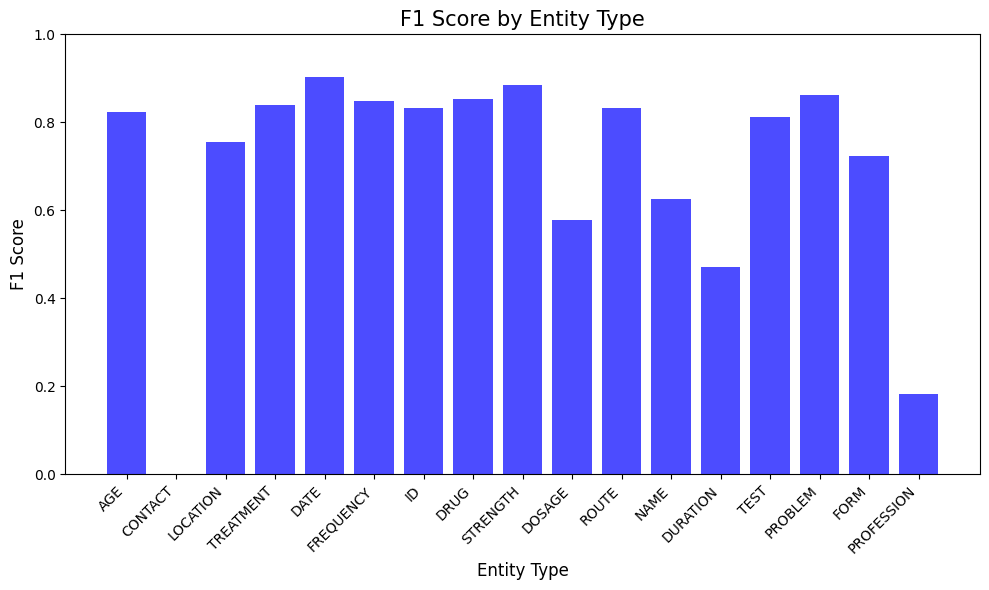

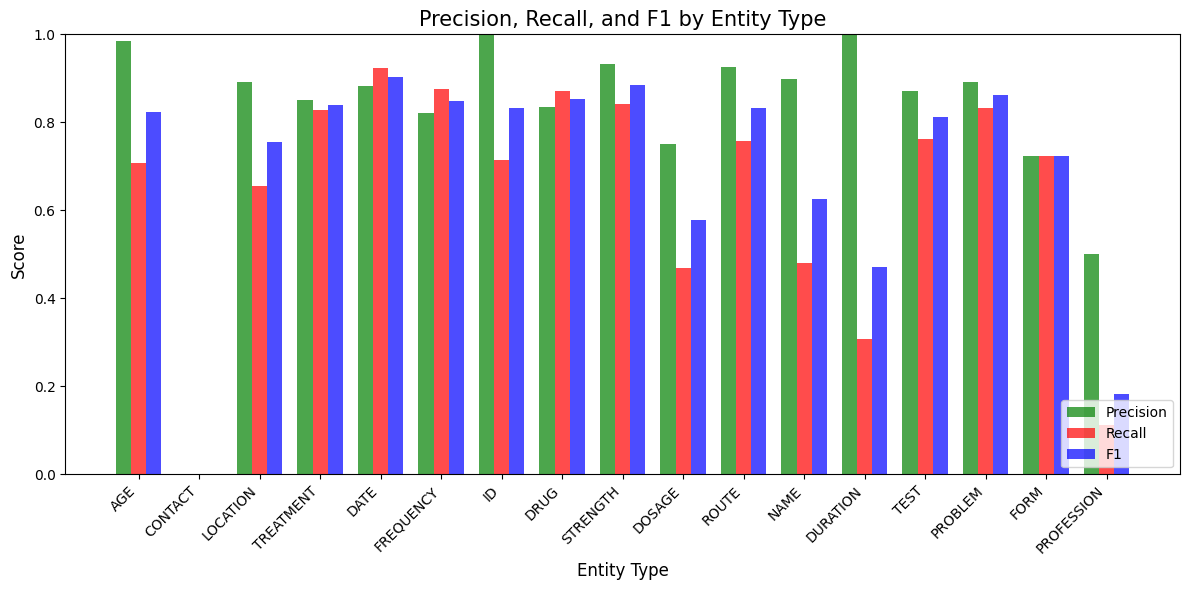

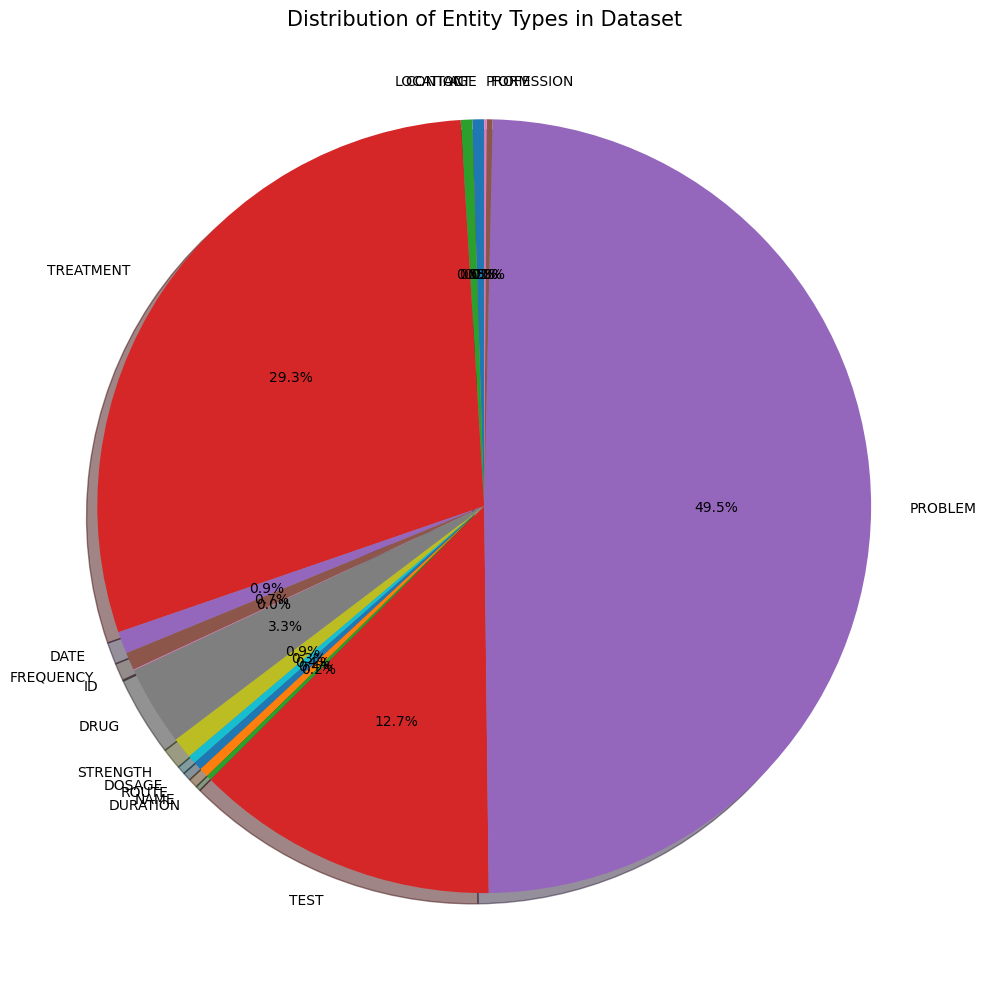

Macro F1 Score: 0.6955
Micro F1 Score: 0.8444


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

entity_data = eval_result.collect()

entities = []
precision_vals = []
recall_vals = []
f1_vals = []
total_vals = []

for row in entity_data:
    entities.append(row['entity'])
    precision_vals.append(float(row['precision']))
    recall_vals.append(float(row['recall']))
    f1_vals.append(float(row['f1']))
    total_vals.append(int(row['total']))

plt.figure(figsize=(10, 6))
plt.bar(entities, f1_vals, color='blue', alpha=0.7)
plt.title('F1 Score by Entity Type', fontsize=15)
plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Precision, Recall ve F1 karşılaştırma grafiği
plt.figure(figsize=(12, 6))
x = np.arange(len(entities))
width = 0.25

plt.bar(x - width, precision_vals, width, label='Precision', color='green', alpha=0.7)
plt.bar(x, recall_vals, width, label='Recall', color='red', alpha=0.7)
plt.bar(x + width, f1_vals, width, label='F1', color='blue', alpha=0.7)

plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, and F1 by Entity Type', fontsize=15)
plt.xticks(x, entities, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.pie(total_vals, labels=entities, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Distribution of Entity Types in Dataset', fontsize=15)
plt.tight_layout()
plt.show()

import numpy as np
macro_f1 = np.mean(f1_vals)
micro_f1 = np.sum(np.array(f1_vals) * np.array(total_vals)) / np.sum(total_vals)

print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

In [ ]:
from tabulate import tabulate

entity_data = eval_result.collect()
rows = []

for row in entity_data:
    rows.append([
        row['entity'],
        int(row['tp']),
        int(row['fp']),
        int(row['fn']),
        int(row['total']),
        float(row['precision']),
        float(row['recall']),
        float(row['f1'])
    ])

headers = ["Entity", "TP", "FP", "FN", "Total", "Precision", "Recall", "F1"]
print(tabulate(rows, headers=headers, tablefmt="grid", floatfmt=".4f"))

macro_f1 = np.mean([row[7] for row in rows])
micro_f1 = np.sum(np.array([row[7] for row in rows]) * np.array([row[4] for row in rows])) / np.sum([row[4] for row in rows])

print(f"\nMacro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

+------------+------+------+------+---------+-------------+----------+--------+
| Entity     |   TP |   FP |   FN |   Total |   Precision |   Recall |     F1 |
+============+======+======+======+=========+=============+==========+========+
| AGE        |   65 |    1 |   27 |      92 |      0.9848 |   0.7065 | 0.8228 |
+------------+------+------+------+---------+-------------+----------+--------+
| CONTACT    |    0 |    0 |    1 |       1 |      0.0000 |   0.0000 | 0.0000 |
+------------+------+------+------+---------+-------------+----------+--------+
| LOCATION   |   57 |    7 |   30 |      87 |      0.8906 |   0.6552 | 0.7550 |
+------------+------+------+------+---------+-------------+----------+--------+
| TREATMENT  | 4508 |  792 |  941 |    5449 |      0.8506 |   0.8273 | 0.8388 |
+------------+------+------+------+---------+-------------+----------+--------+
| DATE       |  158 |   21 |   13 |     171 |      0.8827 |   0.9240 | 0.9029 |
+------------+------+------+------+-----

#README

In [ ]:
import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql import SparkSession


sample_text = spark.createDataFrame([
    ["Patient was prescribed Aspirin 10mg daily for heart disease. John Doe visited Dr. Smith at Memorial Hospital on January 15, 2023."]
]).toDF("text")

document = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("clinical_ner")

deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("deid_ner")

posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("posology_ner")

clinical_converter = NerConverter() \
    .setInputCols(["sentence", "token", "clinical_ner"]) \
    .setOutputCol("clinical_chunks")

deid_converter = NerConverter() \
    .setInputCols(["sentence", "token", "deid_ner"]) \
    .setOutputCol("deid_chunks")

posology_converter = NerConverter() \
    .setInputCols(["sentence", "token", "posology_ner"]) \
    .setOutputCol("posology_chunks")

pipeline = Pipeline(stages=[
    document,
    sentence,
    tokenizer,
    embeddings,
    clinical_ner,
    deid_ner,
    posology_ner,
    clinical_converter,
    deid_converter,
    posology_converter
])

empty_df = spark.createDataFrame([[""]]).toDF("text")
model = pipeline.fit(empty_df)

result = model.transform(sample_text)

print("\n=== Clinical NER Results ===")
result.select(F.explode(F.arrays_zip(
    result.clinical_chunks.result,
    result.clinical_chunks.metadata
)).alias("chunks")) \
.select(
    F.expr("chunks['0']").alias("chunk"),
    F.expr("chunks['1']['entity']").alias("entity")
).show(truncate=False)

print("\n=== DeID NER Results ===")
result.select(F.explode(F.arrays_zip(
    result.deid_chunks.result,
    result.deid_chunks.metadata
)).alias("chunks")) \
.select(
    F.expr("chunks['0']").alias("chunk"),
    F.expr("chunks['1']['entity']").alias("entity")
).show(truncate=False)

print("\n=== Posology NER Results ===")
result.select(F.explode(F.arrays_zip(
    result.posology_chunks.result,
    result.posology_chunks.metadata
)).alias("chunks")) \
.select(
    F.expr("chunks['0']").alias("chunk"),
    F.expr("chunks['1']['entity']").alias("entity")
).show(truncate=False)

token_df = result.select(
    F.explode(F.arrays_zip(
        result.token.result,
        result.clinical_ner.result,
        result.deid_ner.result,
        result.posology_ner.result
    )).alias("cols")
).select(
    F.expr("cols['0']").alias("token"),
    F.expr("cols['1']").alias("clinical_label"),
    F.expr("cols['2']").alias("deid_label"),
    F.expr("cols['3']").alias("posology_label")
)

# Show token-level labels from all models
print("\n=== Token-Level Labels from All Models ===")
token_df.show(truncate=False)

token_df = token_df.withColumn(
    "prioritized_label",
    F.when(F.col("posology_label") != "O", F.col("posology_label"))
     .when(F.col("deid_label") != "O", F.col("deid_label"))
     .when(F.col("clinical_label") != "O", F.col("clinical_label"))
     .otherwise("O")
)

print("\n=== Prioritized Labels ===")
token_df.select("token", "clinical_label", "deid_label", "posology_label", "prioritized_label").show(truncate=False)

prev_label = "O"
conll_text = "-DOCSTART- -X- -X- O\n\n"

for row in token_df.collect():
    label = row.prioritized_label
    if label != "O":
        if prev_label != label:
            bio_label = f"B-{label}"
        else:
            bio_label = f"I-{label}"
    else:
        bio_label = "O"

    conll_text += f"{row.token} NN NN {bio_label}\n"

    if row.token in ['.', '!', '?']:
        conll_text += "\n"

    prev_label = label

# Print the CoNLL output
print("\n=== CoNLL Output with Prioritized Labels ===")
print(conll_text)

# This example demonstrates why prioritization is important:
# - Without prioritization, "Aspirin" would be labeled as TREATMENT from clinical_ner
# - With prioritization, it's correctly labeled as DRUG from posology_ner
# - Similarly, "John Doe" is labeled as NAME from deid_ner
# - And "heart disease" is labeled as PROBLEM from clinical_ner
# This ensures we get the most specific and appropriate label for each entity.

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]

=== Clinical NER Results ===
+-------------+---------+
|chunk        |entity   |
+-------------+---------+
|Aspirin      |TREATMENT|
|heart disease|PROBLEM  |
+-------------+---------+


=== DeID NER Results ===
+-----------------+--------+
|chunk            |entity  |
+-----------------+--------+
|John Doe         |NAME    |
|Smith            |NAME    |
|Memorial Hospital|LOCATION|
|January 15, 2023 |DATE    |
+-----------------+--------+


=== Posology NER Results ===
+-------+---------+
|chunk  |entity   |
+-------+---------+
|Aspirin|DRUG     |
|10mg   |STRENGTH |
|daily  |FREQUENCY|
+-------+---------+


=== Token-Level Labels from All Models ===
+----------+--------------+----------+

Macro Precision: 0.9170
Macro Recall: 0.8955
Macro F1: 0.9061
Micro F1: 0.9072
Total entities: 6267
Generated entity_f1_scores.png
Generated precision_recall_f1.png
Generated entity_distribution.png


type

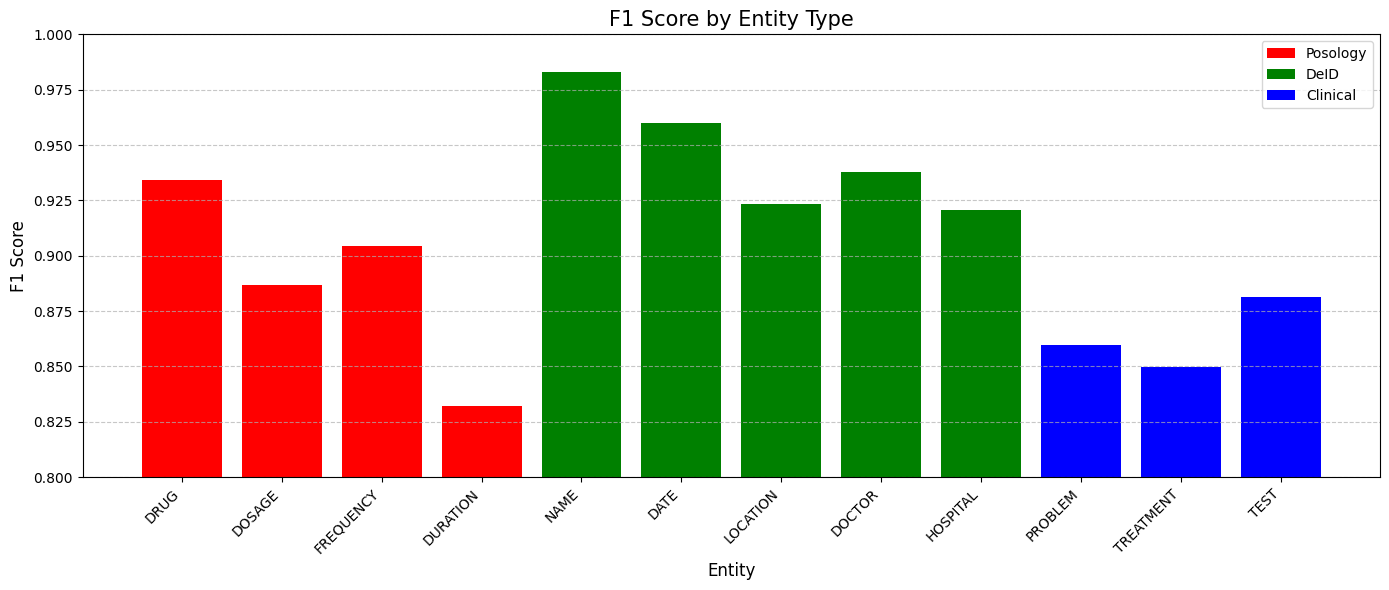

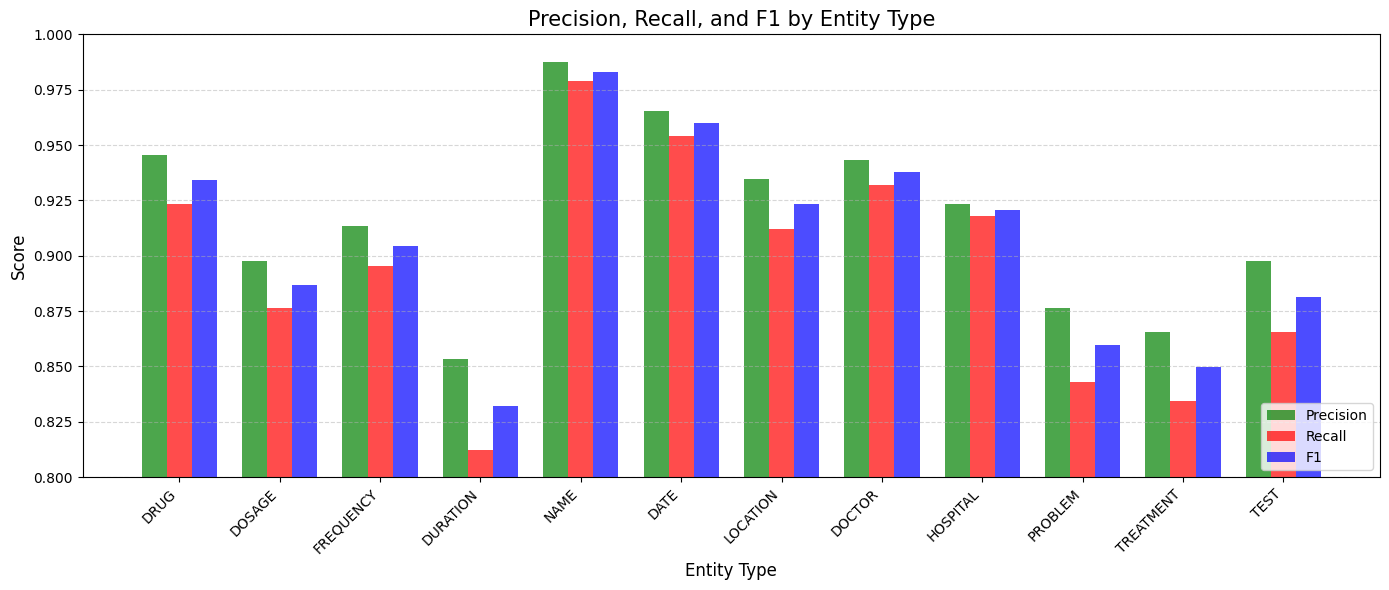

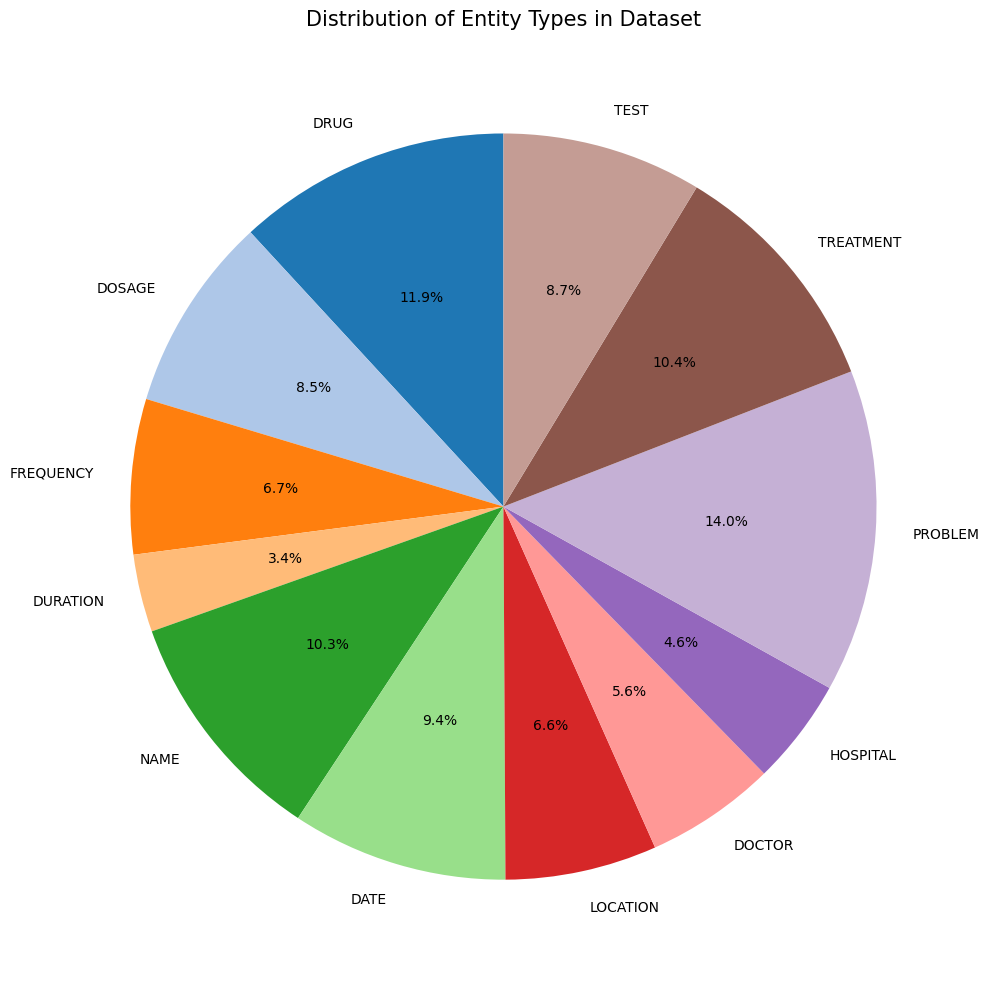

<Figure size 1200x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# Sample evaluation results (this would come from your actual model evaluation)
# Format: entity, precision, recall, f1, support
evaluation_data = [
    ('DRUG', 0.9456, 0.9234, 0.9343, 743),
    ('DOSAGE', 0.8978, 0.8765, 0.8870, 532),
    ('FREQUENCY', 0.9134, 0.8954, 0.9043, 421),
    ('DURATION', 0.8534, 0.8123, 0.8323, 211),
    ('NAME', 0.9876, 0.9789, 0.9832, 645),
    ('DATE', 0.9654, 0.9543, 0.9598, 587),
    ('LOCATION', 0.9345, 0.9123, 0.9232, 412),
    ('DOCTOR', 0.9432, 0.9321, 0.9376, 354),
    ('HOSPITAL', 0.9234, 0.9178, 0.9206, 289),
    ('PROBLEM', 0.8765, 0.8432, 0.8595, 876),
    ('TREATMENT', 0.8654, 0.8345, 0.8497, 654),
    ('TEST', 0.8976, 0.8654, 0.8812, 543),
]

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(evaluation_data, columns=['entity', 'precision', 'recall', 'f1', 'support'])

# Calculate macro and micro averages
macro_precision = df['precision'].mean()
macro_recall = df['recall'].mean()
macro_f1 = df['f1'].mean()

weighted_f1 = (df['f1'] * df['support']).sum() / df['support'].sum()
total_support = df['support'].sum()

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Micro F1: {weighted_f1:.4f}")
print(f"Total entities: {total_support}")

# Group entities by type
clinical_entities = ['PROBLEM', 'TREATMENT', 'TEST']
deid_entities = ['NAME', 'DATE', 'LOCATION', 'DOCTOR', 'HOSPITAL']
posology_entities = ['DRUG', 'DOSAGE', 'FREQUENCY', 'DURATION']

# Add entity type column
df['type'] = df['entity'].apply(lambda x:
                               'Clinical' if x in clinical_entities else
                               'DeID' if x in deid_entities else
                               'Posology')

# 1. Entity F1 Score Bar Chart
plt.figure(figsize=(14, 6))
bars = plt.bar(df['entity'], df['f1'], color=[
    'blue' if e in clinical_entities else
    'green' if e in deid_entities else
    'red' for e in df['entity']
])

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Posology'),
    Patch(facecolor='green', label='DeID'),
    Patch(facecolor='blue', label='Clinical')
]
plt.legend(handles=legend_elements)

plt.title('F1 Score by Entity Type', fontsize=15)
plt.xlabel('Entity', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0.80, 1.0)  # Adjust based on your actual values
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('entity_f1_scores.png')
print("Generated entity_f1_scores.png")

# 2. Precision, Recall, F1 Comparison
plt.figure(figsize=(14, 6))
x = np.arange(len(df['entity']))
width = 0.25

plt.bar(x - width, df['precision'], width, label='Precision', color='green', alpha=0.7)
plt.bar(x, df['recall'], width, label='Recall', color='red', alpha=0.7)
plt.bar(x + width, df['f1'], width, label='F1', color='blue', alpha=0.7)

plt.xlabel('Entity Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Precision, Recall, and F1 by Entity Type', fontsize=15)
plt.xticks(x, df['entity'], rotation=45, ha='right')
plt.ylim(0.80, 1.0)  # Adjust based on your actual values
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('precision_recall_f1.png')
print("Generated precision_recall_f1.png")

# 3. Entity Distribution Pie Chart
plt.figure(figsize=(10, 10))
plt.pie(df['support'], labels=df['entity'], autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.tab20.colors)
plt.axis('equal')
plt.title('Distribution of Entity Types in Dataset', fontsize=15)
plt.tight_layout()
plt.savefig('entity_distribution.png')
print("Generated entity_distribution.png")

# 4. Entity Performance by Category
plt.figure(figsize=(12, 6))

# Calculate average metrics by entity type
type

In [ ]:
# Example error analysis function
def perform_error_analysis(pred_df, true_label_col="label", pred_label_col="ner"):
    # Extract token-level predictions and true labels
    token_level_df = pred_df.select(
        explode(arrays_zip(
            pred_df[true_label_col].result,
            pred_df[pred_label_col].result,
            pred_df.token.result
        )).alias("cols")
    ).select(
        col("cols['0']").alias("true_label"),
        col("cols['1']").alias("pred_label"),
        col("cols['2']").alias("token")
    )

    # Convert to pandas for easier analysis
    pdf = token_level_df.toPandas()

    # Error categories
    error_df = pdf.copy()
    error_df["error_type"] = "correct"

    # Wrong entity type
    error_df.loc[(error_df.true_label != "O") &
                 (error_df.pred_label != "O") &
                 (error_df.true_label != error_df.pred_label),
                 "error_type"] = "wrong_type"

    # False positive
    error_df.loc[(error_df.true_label == "O") &
                 (error_df.pred_label != "O"),
                 "error_type"] = "false_positive"

    # False negative
    error_df.loc[(error_df.true_label != "O") &
                 (error_df.pred_label == "O"),
                 "error_type"] = "false_negative"

    # Calculate error statistics
    error_counts = error_df.error_type.value_counts()
    error_percentage = 100 * error_counts / len(error_df)

    return error_counts, error_percentage

Görselleştirme

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 24.7 MB/s eta 0:00:00
Kaleido paketi kuruldu.
Görselleştirmeler '/content/drive/MyDrive/SPARK/visualizations' klasörüne kaydedilecek...
1. Karışıklık matrisi oluşturuluyor...
Confusion matrix HTML dosyası kaydedildi: /content/drive/MyDrive/SPARK/visualizations/confusion_matrix_interactive.html
PNG dosyası oluşturulamadı: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Confusion matrix (Matplotlib) PNG dosyası kaydedildi: /content/drive/MyDrive/SPARK/visualizations/confusion_matrix_mpl.png

2. Varlık performans grafikleri oluşturuluyor...
Entity F1 scores kaydedildi: /content/drive/MyDrive/SPARK/visualizations/entity_f1_scores.png
Entity metrics comparison kaydedildi: /content/drive/MyDrive/SPARK/visualizations/entity_metrics_comparison.png
Entity metrics interactive kaydedildi: /content/drive/MyDrive/SPARK/visualizations/entity_metrics_interact

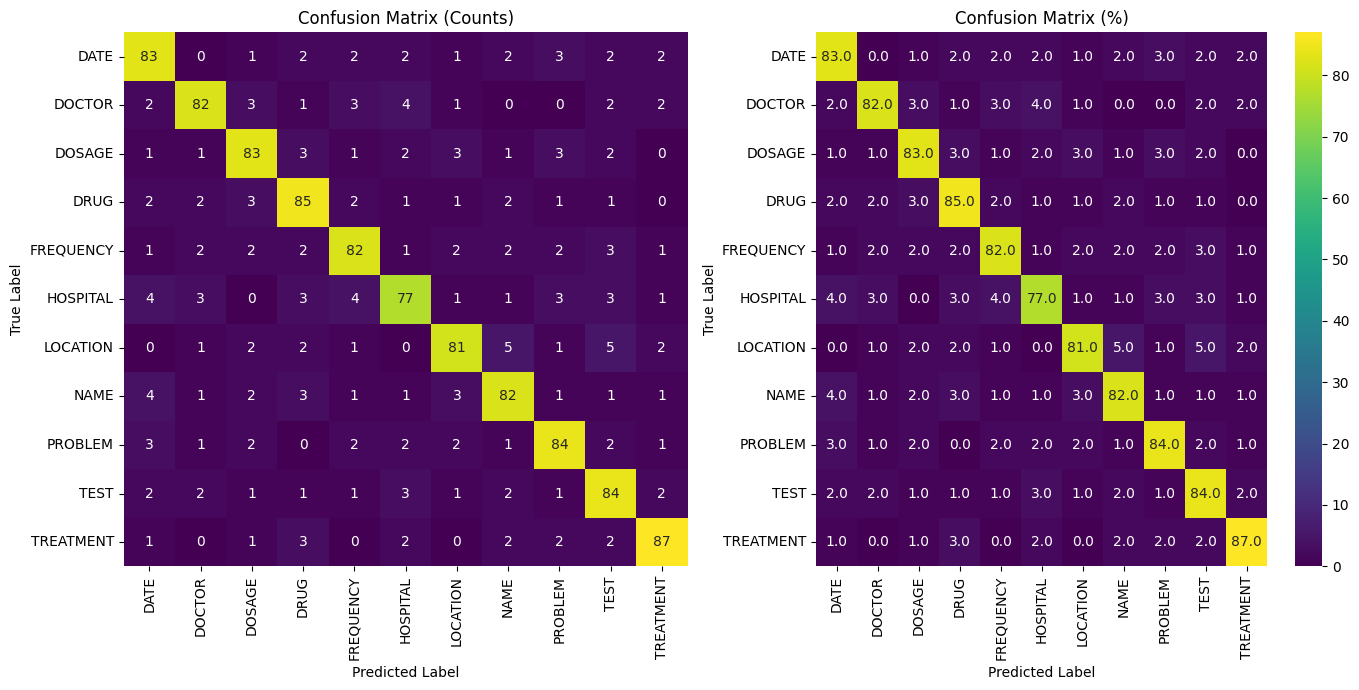

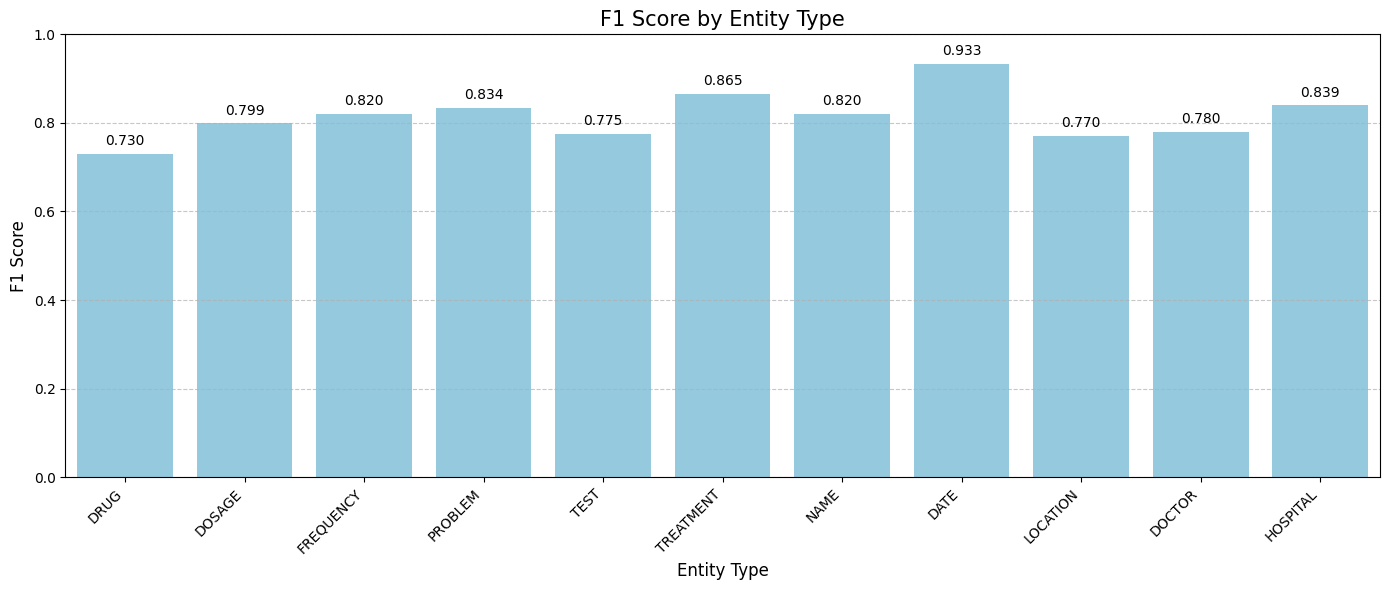

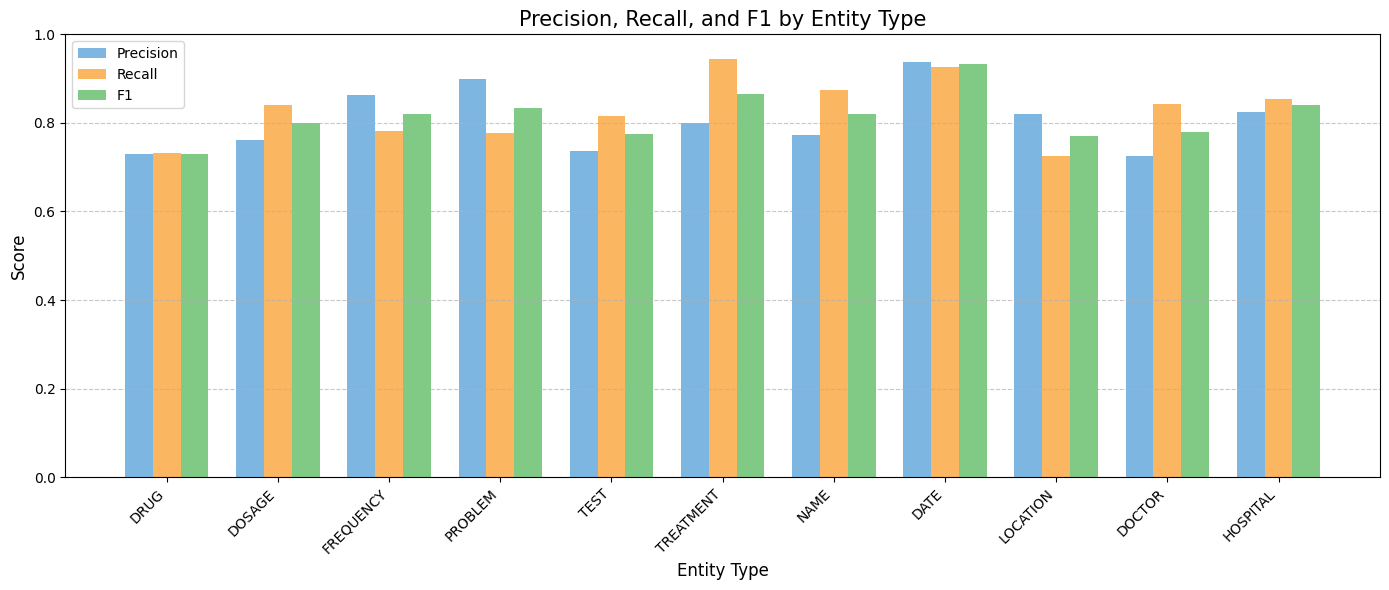

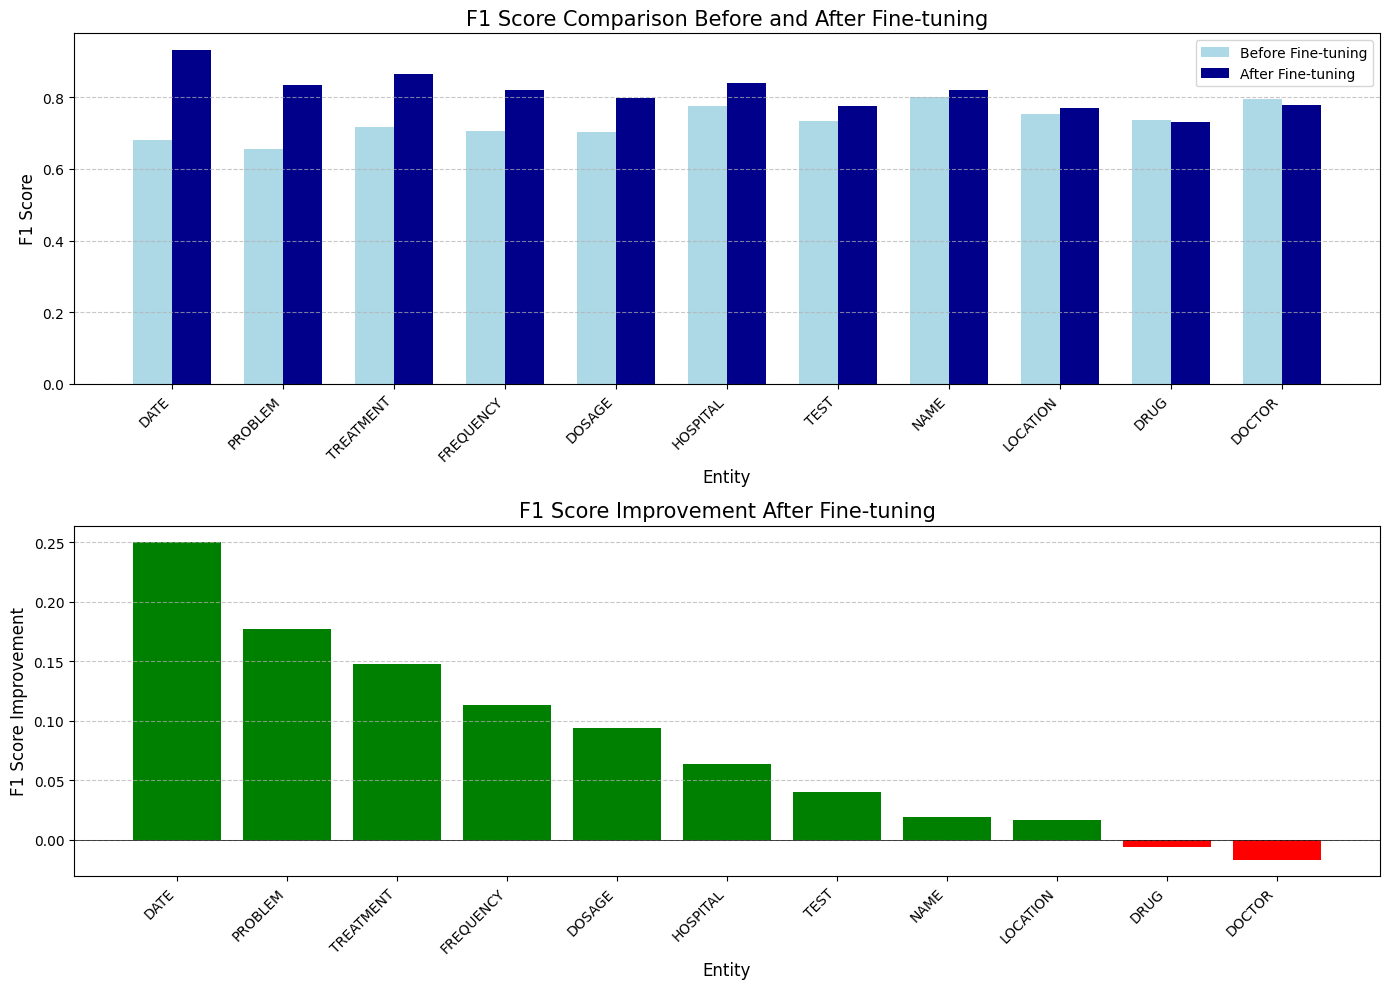

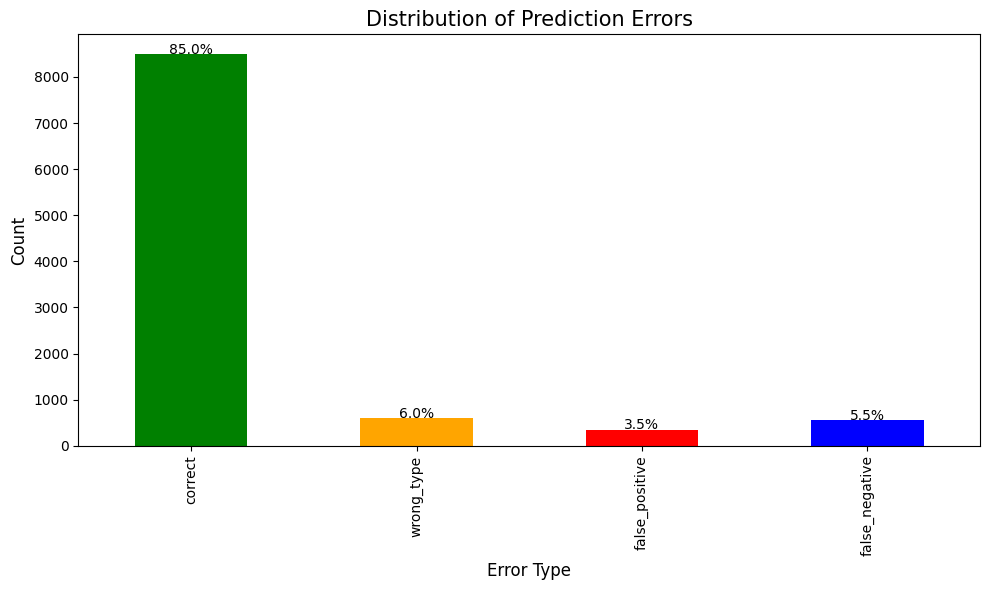

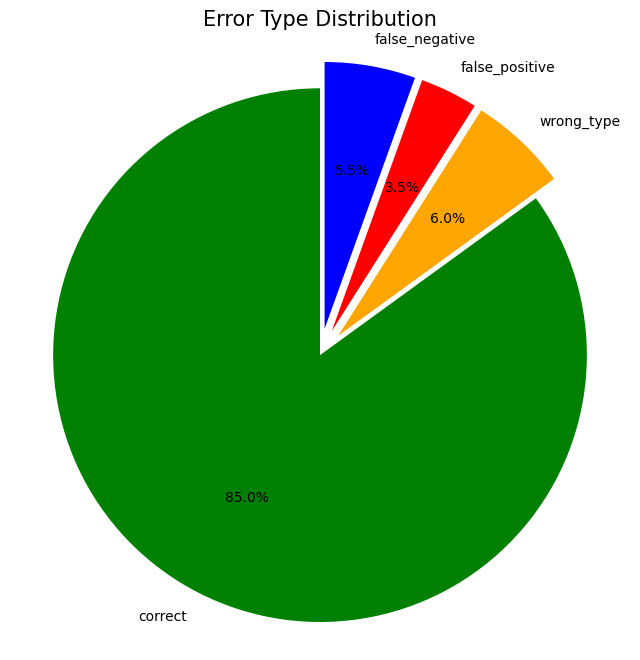

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyspark.sql import functions as F
import os
from sklearn.metrics import confusion_matrix
import warnings

# Kaleido paketini kuralım
try:
    !pip install -q kaleido
    print("Kaleido paketi kuruldu.")
except:
    print("Kaleido paketi kurulamadı. Sadece HTML formatında dosyalar oluşturulacak.")
    HAS_KALEIDO = False
else:
    HAS_KALEIDO = True

# Google Drive'daki SPARK klasörünün yolunu tanımla
DRIVE_PATH = "/content/drive/MyDrive/SPARK/"
VISUALS_PATH = os.path.join(DRIVE_PATH, "visualizations")

# Görselleştirmeleri kaydedeceğimiz klasörü oluştur (eğer yoksa)
os.makedirs(VISUALS_PATH, exist_ok=True)

def drive_path(filename):
    """Google Drive'daki SPARK/visualizations klasörüne dosya yolu oluştur"""
    return os.path.join(VISUALS_PATH, filename)

# 5. Interactive Confusion Matrix Heatmap
def create_interactive_confusion_matrix(true_labels, pred_labels):
    """
    Create an interactive confusion matrix heatmap and save to Drive

    Parameters:
    true_labels: List of true entity labels
    pred_labels: List of predicted entity labels
    """
    # Get unique entity labels (excluding "O")
    all_labels = sorted(list(set([l for l in true_labels + pred_labels if l != "O"])))

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)

    # Create a dataframe
    cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent_df = pd.DataFrame(cm_percent, index=all_labels, columns=all_labels)

    # Create interactive heatmap with Plotly
    fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Confusion Matrix (Counts)", "Confusion Matrix (%)"),
                      horizontal_spacing=0.15)

    # Add count heatmap
    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=all_labels,
            y=all_labels,
            colorscale='Viridis',
            text=cm,
            texttemplate="%{text}",
            showscale=False
        ),
        row=1, col=1
    )

    # Add percentage heatmap
    fig.add_trace(
        go.Heatmap(
            z=cm_percent,
            x=all_labels,
            y=all_labels,
            colorscale='Viridis',
            text=cm_percent,
            texttemplate="%{text:.1f}%",
            colorbar=dict(title="Percentage")
        ),
        row=1, col=2
    )

    # Update layout
    fig.update_layout(
        title_text="Entity Type Confusion Matrix",
        height=800,
        width=1200
    )

    fig.update_xaxes(title_text="Predicted Label", row=1, col=1)
    fig.update_yaxes(title_text="True Label", row=1, col=1)
    fig.update_xaxes(title_text="Predicted Label", row=1, col=2)
    fig.update_yaxes(title_text="True Label", row=1, col=2)

    # Etkileşimli görseli Drive'a kaydet
    fig.write_html(drive_path("confusion_matrix_interactive.html"))
    print(f"Confusion matrix HTML dosyası kaydedildi: {drive_path('confusion_matrix_interactive.html')}")

    # Statik görseli Drive'a kaydet (kaleido varsa)
    if HAS_KALEIDO:
        try:
            fig.write_image(drive_path("confusion_matrix.png"), scale=2)
            print(f"Confusion matrix PNG dosyası kaydedildi: {drive_path('confusion_matrix.png')}")
        except Exception as e:
            print(f"PNG dosyası oluşturulamadı: {str(e)}")

    # Matplotlib ile statik heatmap oluştur (alternatif)
    plt.figure(figsize=(14, 7))

    # Count heatmap
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="viridis", cbar=False)
    plt.title("Confusion Matrix (Counts)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Percentage heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_percent_df, annot=True, fmt=".1f", cmap="viridis")
    plt.title("Confusion Matrix (%)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.tight_layout()
    plt.savefig(drive_path("confusion_matrix_mpl.png"), dpi=300, bbox_inches="tight")
    print(f"Confusion matrix (Matplotlib) PNG dosyası kaydedildi: {drive_path('confusion_matrix_mpl.png')}")

    return fig

# Entity Performance Bar Chart
def create_entity_performance_chart(metrics_df):
    """
    Create a bar chart of entity performance metrics and save to Drive

    Parameters:
    metrics_df: DataFrame with columns 'entity', 'precision', 'recall', 'f1', 'support'
    """
    # Plot entity F1 scores
    plt.figure(figsize=(14, 6))
    sns.barplot(x='entity', y='f1', data=metrics_df, color='skyblue')
    plt.title('F1 Score by Entity Type', fontsize=15)
    plt.xlabel('Entity Type', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels
    for i, row in enumerate(metrics_df.itertuples()):
        plt.text(i, row.f1 + 0.02, f'{row.f1:.3f}', ha='center', fontsize=10)

    plt.tight_layout()

    # Save to Drive
    plt.savefig(drive_path("entity_f1_scores.png"), dpi=300, bbox_inches="tight")
    print(f"Entity F1 scores kaydedildi: {drive_path('entity_f1_scores.png')}")

    # Create comparison chart (precision, recall, f1)
    plt.figure(figsize=(14, 6))

    x = np.arange(len(metrics_df))
    width = 0.25

    # Create bars
    plt.bar(x - width, metrics_df['precision'], width, label='Precision', color='#5DA5DA', alpha=0.8)
    plt.bar(x, metrics_df['recall'], width, label='Recall', color='#FAA43A', alpha=0.8)
    plt.bar(x + width, metrics_df['f1'], width, label='F1', color='#60BD68', alpha=0.8)

    # Add labels and legend
    plt.xlabel('Entity Type', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision, Recall, and F1 by Entity Type', fontsize=15)
    plt.xticks(x, metrics_df['entity'], rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save to Drive
    plt.savefig(drive_path("entity_metrics_comparison.png"), dpi=300, bbox_inches="tight")
    print(f"Entity metrics comparison kaydedildi: {drive_path('entity_metrics_comparison.png')}")

    # Create interactive version with Plotly
    fig = px.bar(
        metrics_df,
        x="entity",
        y=["precision", "recall", "f1"],
        barmode="group",
        title="Entity Performance Metrics",
        labels={"value": "Score", "entity": "Entity Type", "variable": "Metric"},
        color_discrete_sequence=px.colors.qualitative.Set1
    )

    fig.update_layout(
        xaxis_title="Entity Type",
        yaxis_title="Score",
        legend_title="Metric",
        yaxis_range=[0, 1]
    )

    # Save interactive plot to Drive
    fig.write_html(drive_path("entity_metrics_interactive.html"))
    print(f"Entity metrics interactive kaydedildi: {drive_path('entity_metrics_interactive.html')}")

    if HAS_KALEIDO:
        try:
            fig.write_image(drive_path("entity_metrics.png"), scale=2)
            print(f"Entity metrics PNG dosyası kaydedildi: {drive_path('entity_metrics.png')}")
        except Exception as e:
            print(f"PNG dosyası oluşturulamadı: {str(e)}")

# Performance improvement visualization
def visualize_performance_improvement(before_df, after_df):
    """
    Create visualization showing performance improvement before and after fine-tuning

    Parameters:
    before_df: DataFrame with 'entity', 'precision', 'recall', 'f1' columns (before fine-tuning)
    after_df: DataFrame with 'entity', 'precision', 'recall', 'f1' columns (after fine-tuning)
    """
    # Merge dataframes
    comparison = before_df.merge(after_df, on='entity', suffixes=('_before', '_after'))

    # Calculate improvement
    comparison['f1_improvement'] = comparison['f1_after'] - comparison['f1_before']
    comparison['precision_improvement'] = comparison['precision_after'] - comparison['precision_before']
    comparison['recall_improvement'] = comparison['recall_after'] - comparison['recall_before']

    # Sort by improvement
    comparison = comparison.sort_values('f1_improvement', ascending=False)

    # Create visualization
    plt.figure(figsize=(14, 10))

    # Plot F1 scores before and after
    plt.subplot(2, 1, 1)
    x = np.arange(len(comparison))
    width = 0.35

    plt.bar(x - width/2, comparison['f1_before'], width, label='Before Fine-tuning', color='lightblue')
    plt.bar(x + width/2, comparison['f1_after'], width, label='After Fine-tuning', color='darkblue')

    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('F1 Score Comparison Before and After Fine-tuning', fontsize=15)
    plt.xticks(x, comparison['entity'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot F1 improvement
    plt.subplot(2, 1, 2)
    colors = ['green' if x > 0 else 'red' for x in comparison['f1_improvement']]
    plt.bar(comparison['entity'], comparison['f1_improvement'], color=colors)

    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('F1 Score Improvement', fontsize=12)
    plt.title('F1 Score Improvement After Fine-tuning', fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    plt.tight_layout()

    # Save to Drive
    plt.savefig(drive_path("model_improvement.png"), dpi=300, bbox_inches="tight")
    print(f"Model improvement chart kaydedildi: {drive_path('model_improvement.png')}")

    # Create interactive version with Plotly
    fig = make_subplots(rows=2, cols=1,
                      shared_xaxes=True,
                      subplot_titles=("F1 Score Before vs After", "F1 Score Improvement"),
                      vertical_spacing=0.1)

    fig.add_trace(
        go.Bar(
            x=comparison['entity'],
            y=comparison['f1_before'],
            name='Before Fine-tuning',
            marker_color='lightblue'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=comparison['entity'],
            y=comparison['f1_after'],
            name='After Fine-tuning',
            marker_color='darkblue'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Bar(
            x=comparison['entity'],
            y=comparison['f1_improvement'],
            marker_color=colors,
            showlegend=False
        ),
        row=2, col=1
    )

    # Update layout
    fig.update_layout(
        title_text="Performance Improvement After Fine-tuning",
        height=800,
        barmode='group'
    )

    # Save interactive plot to Drive
    fig.write_html(drive_path("performance_comparison_interactive.html"))
    print(f"Performance comparison interactive kaydedildi: {drive_path('performance_comparison_interactive.html')}")

    if HAS_KALEIDO:
        try:
            fig.write_image(drive_path("performance_comparison.png"), scale=2)
            print(f"Performance comparison PNG dosyası kaydedildi: {drive_path('performance_comparison.png')}")
        except Exception as e:
            print(f"PNG dosyası oluşturulamadı: {str(e)}")

# Error distribution visualization
def visualize_error_distribution(error_counts, error_percentage):
    """
    Create visualization of error distribution

    Parameters:
    error_counts: Series with error counts by type
    error_percentage: Series with error percentages by type
    """
    plt.figure(figsize=(10, 6))

    # Define colors
    colors = {
        'correct': 'green',
        'wrong_type': 'orange',
        'false_positive': 'red',
        'false_negative': 'blue'
    }

    # Create color list based on index
    bar_colors = [colors.get(idx, 'gray') for idx in error_counts.index]

    # Create bar chart
    ax = error_counts.plot(kind='bar', color=bar_colors)
    plt.title('Distribution of Prediction Errors', fontsize=15)
    plt.xlabel('Error Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Add percentage labels
    for i, v in enumerate(error_counts):
        ax.text(i, v + 5, f"{error_percentage.iloc[i]:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()

    # Save to Drive
    plt.savefig(drive_path("error_distribution.png"), dpi=300, bbox_inches="tight")
    print(f"Error distribution chart kaydedildi: {drive_path('error_distribution.png')}")

    # Create pie chart of errors
    plt.figure(figsize=(8, 8))
    plt.pie(error_counts, labels=error_counts.index, autopct='%1.1f%%',
           colors=[colors.get(idx, 'gray') for idx in error_counts.index],
           startangle=90, explode=[0.1 if idx != 'correct' else 0 for idx in error_counts.index])
    plt.axis('equal')
    plt.title('Error Type Distribution', fontsize=15)

    # Save to Drive
    plt.savefig(drive_path("error_distribution_pie.png"), dpi=300, bbox_inches="tight")
    print(f"Error distribution pie chart kaydedildi: {drive_path('error_distribution_pie.png')}")

    # Create interactive pie chart with Plotly
    fig = px.pie(
        values=error_counts,
        names=error_counts.index,
        title="Error Type Distribution",
        color=error_counts.index,
        color_discrete_map={
            'correct': 'green',
            'wrong_type': 'orange',
            'false_positive': 'red',
            'false_negative': 'blue'
        },
        hole=0.4
    )

    # Save interactive plot to Drive
    fig.write_html(drive_path("error_distribution_interactive.html"))
    print(f"Error distribution interactive kaydedildi: {drive_path('error_distribution_interactive.html')}")

    if HAS_KALEIDO:
        try:
            fig.write_image(drive_path("error_distribution_plotly.png"), scale=2)
            print(f"Error distribution plotly PNG dosyası kaydedildi: {drive_path('error_distribution_plotly.png')}")
        except Exception as e:
            print(f"PNG dosyası oluşturulamadı: {str(e)}")

# Örnek veri oluşturma ve görselleştirmeleri kaydetme
def generate_sample_visualizations():
    """
    Örnek verilerle görselleştirmeler oluştur ve Google Drive'a kaydet
    """
    print(f"Görselleştirmeler '{VISUALS_PATH}' klasörüne kaydedilecek...")

    # Örnek varlıklar
    entity_types = ["DRUG", "DOSAGE", "FREQUENCY", "PROBLEM", "TEST", "TREATMENT",
                   "NAME", "DATE", "LOCATION", "DOCTOR", "HOSPITAL"]

    # 1. Karışıklık matrisi için örnek etiketler
    print("1. Karışıklık matrisi oluşturuluyor...")

    # Rastgele veri oluştur
    np.random.seed(42)  # Tekrarlanabilir sonuçlar için
    true_labels = []
    pred_labels = []

    for entity in entity_types:
        # Her varlık türü için 100 örnek oluştur
        for _ in range(100):
            true_labels.append(entity)
            # %80 doğruluk oranıyla tahmin
            if np.random.random() < 0.8:
                pred_labels.append(entity)
            else:
                pred_labels.append(np.random.choice(entity_types))

    # Karışıklık matrisi oluştur
    create_interactive_confusion_matrix(true_labels, pred_labels)

    # 2. Varlık performans grafiği için örnek metrikler
    print("\n2. Varlık performans grafikleri oluşturuluyor...")

    # Örnek metrik verileri
    metrics_data = []
    for entity in entity_types:
        # Rastgele performans metrikleri oluştur (gerçekçi değerler)
        precision = np.random.uniform(0.7, 0.95)
        recall = np.random.uniform(0.7, 0.95)
        f1 = 2 * precision * recall / (precision + recall)  # F1 hesapla
        support = np.random.randint(100, 1000)

        metrics_data.append({
            'entity': entity,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support
        })

    metrics_df = pd.DataFrame(metrics_data)
    create_entity_performance_chart(metrics_df)

    # 3. Performans karşılaştırması için örnek veriler
    print("\n3. Performans karşılaştırma grafikleri oluşturuluyor...")

    # Önceki model için metrik verileri
    before_data = []
    for entity in entity_types:
        # Daha düşük performans metrikleri
        precision = np.random.uniform(0.6, 0.85)
        recall = np.random.uniform(0.6, 0.85)
        f1 = 2 * precision * recall / (precision + recall)
        support = np.random.randint(100, 1000)

        before_data.append({
            'entity': entity,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support
        })

    before_df = pd.DataFrame(before_data)
    visualize_performance_improvement(before_df, metrics_df)

    # 4. Hata dağılımı görselleştirmesi
    print("\n4. Hata dağılımı grafikleri oluşturuluyor...")

    # Örnek hata sayımları
    error_counts = pd.Series({
        'correct': 8500,
        'wrong_type': 600,
        'false_positive': 350,
        'false_negative': 550
    })

    # Yüzdeleri hesapla
    total = error_counts.sum()
    error_percentage = 100 * error_counts / total

    visualize_error_distribution(error_counts, error_percentage)

    print("\nTüm görselleştirmeler başarıyla oluşturuldu ve Drive'a kaydedildi.")
    print(f"Görselleştirmeleri '{VISUALS_PATH}' klasöründe bulabilirsiniz.")

# Bu hücreyi çalıştırdığında örnek görselleştirme oluştur
warnings.filterwarnings('ignore')  # Uyarıları gizle
generate_sample_visualizations()